In [84]:
##Load in Data
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader


amazon = pd.read_csv('AMAZON_daily.csv')
amazon=amazon[['Date', 'Close']]

apple = pd.read_csv('APPLE_daily.csv')
apple=apple[['Date', 'Close']]

google = pd.read_csv('GOOGLE_daily.csv')
google=google[['Date', 'Close']]

meta = pd.read_csv('META_daily.csv')
meta=meta[['Date', 'Close']]

netflix = pd.read_csv('NETFLIX_daily.csv')
netflix=netflix[['Date', 'Close']]

#my GPU is AMD Radeon (too complicated to use on my computer)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [85]:
from copy import deepcopy as dc
#Prepare the data for the LSTM. Lookback 7 actually means we are looking back 

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{n_steps+1-i})'] = df['Close'].shift(n_steps+1-i)

    df.dropna(inplace=True)

    return df

lookback=7
amazon_shift = prepare_dataframe_for_lstm(amazon, lookback)

apple_shift = prepare_dataframe_for_lstm(apple, lookback)

google_shift = prepare_dataframe_for_lstm(google, lookback)

meta_shift = prepare_dataframe_for_lstm(meta, lookback)

netflix_shift= prepare_dataframe_for_lstm(netflix, lookback)

In [86]:
# Adding one hot encoded variables by hand and changing dataframe to numpy, since numpy is convertible to tensors.
amazon_np = amazon_shift.to_numpy() # won't show date column since data is index
amazon_np= np.hstack((amazon_np, np.ones((len(amazon_np),1))))
amazon_np = np.hstack((amazon_np, np.zeros((len(amazon_np), 4))))

apple_np = apple_shift.to_numpy()
apple_np = np.hstack((apple_np, np.zeros((len(apple_np), 1))))
apple_np = np.hstack((apple_np, np.ones((len(apple_np), 1))))
apple_np = np.hstack((apple_np, np.zeros((len(apple_np), 3))))

google_np = google_shift.to_numpy()
google_np = np.hstack((google_np, np.zeros((len(google_np), 2))))
google_np = np.hstack((google_np, np.ones((len(google_np), 1))))
google_np = np.hstack((google_np, np.zeros((len(google_np), 2))))

meta_np = meta_shift.to_numpy()
meta_np = np.hstack((meta_np, np.zeros((len(meta_np), 3))))
meta_np = np.hstack((meta_np, np.ones((len(meta_np), 1))))
meta_np = np.hstack((meta_np, np.zeros((len(meta_np), 1))))

netflix_np = netflix_shift.to_numpy()
netflix_np = np.hstack((netflix_np, np.zeros((len(netflix_np),4))))
netflix_np = np.hstack((netflix_np, np.ones((len(netflix_np), 1))))

shifted_np = np.vstack((amazon_np, apple_np, google_np, meta_np, netflix_np)) #combining that data from all companies. 

In [87]:
#Getting rid of earlier years to start in 2013, after all companies have been founded
first_day = np.datetime64('2013-01-01 00:00:00')
ind = shifted_np[:,0] >= first_day
shifted_np = shifted_np[ind]

#creating a cutoff date for training/testing (can't just cut off end since the companies are not mixed.) Creates an equal amount of each company in training, testing, etc.
cutoff_date = np.quantile(shifted_np[:,0],0.8)
test_ind = shifted_np[:,0] >= cutoff_date
train_ind = shifted_np[:,0] < cutoff_date

shifted_np = np.delete(shifted_np, 0, 1) #delete dates since LSTM doesn't explicitly train on dates

In [88]:
from sklearn.preprocessing import MinMaxScaler
#transform via MinMax to reduce the effect of outliers/inflation

scalery = MinMaxScaler(feature_range=(-1,1)) #video said feature_range=(-1,1)
#this does std = (x-min)(max-min), x_new = std*(min-max)+min

shifted_np[:,0] = (scalery.fit_transform(shifted_np[:,0].reshape(-1,1))).reshape(-1)

scalerx = MinMaxScaler(feature_range=(-1,1))
shifted_np[:,1:lookback+1] = scalerx.fit_transform(shifted_np[:,1:lookback+1])

In [89]:
#Assign input and output
X =shifted_np[:,1:]
y=shifted_np[:,0]

#Spliting into train and test
X_train = X[train_ind]
X_test = X[test_ind]
y_train = y[train_ind]
y_test = y[test_ind]

#pytorch wants another dimension so:
X_train_np = (X_train.reshape((-1, lookback+5, 1))).astype(float)
X_test_np = (X_test.reshape((-1,lookback+5, 1))).astype(float)

y_train_np = (y_train.reshape((-1,1))).astype(float)
y_test_np = (y_test.reshape((-1,1))).astype(float)

In [90]:
#Wrap in tensors for pytorch
X_train = torch.tensor(X_train_np).float()
X_test = torch.tensor(X_test_np).float()
y_train = torch.tensor(y_train_np).float()
y_test = torch.tensor(y_test_np).float()

#Turn into dataset object (need custom class) - Got this custom class from tutorial video
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X =X
        self.y =y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i): #square brackets indexing
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [91]:
#Wrap Datsets in DataLoaders to get batches

from torch.utils.data import DataLoader

batch_size=32 #from hyperparameter tuning
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [92]:
##Building the model

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, lookback, num_lin_lay, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.lookback =lookback
        self.num_stacked_layers = num_stacked_layers
        self.num_lin_lay = num_lin_lay

        #need this for grid search
        effective_dropout = dropout if num_stacked_layers > 1 else 0.0 #in both cases, actually not using dropout since only have 1 stacked layer.

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, dropout=effective_dropout,batch_first=True)
        if num_lin_lay == 2:#num_lin_lay must be either 1 and 2
            self.fc2 = nn.Linear(hidden_size+5, hidden_size+5)        
        self.fc = nn.Linear(hidden_size+5, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #h0 is gate vectors, must initialize with particular shape
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x[:,:lookback],(h0, c0))
        temporary = torch.cat((out[:,-1,:], x[:, lookback:,0]), dim=1)
        
        if self.num_lin_lay ==2:
            temp2 = self.fc2(temporary)
            out = self.fc(temp2)
        else:
            out = self.fc(temporary)
        return out

In [93]:
##Training function
def train_one_epoch(m,epoch, optimizer, loss_function, trainload, device):
    m.train(True) #set to training mode
    print(f'Epoch: {epoch+1}')
    running_loss=0.0

    for batch_index, batch in enumerate(trainload):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #gets a batch and puts on device we use

        output = m(x_batch) #gets output of model
        loss = loss_function(output, y_batch) #compares outputs to ground truth
        running_loss += loss.item()
        optimizer.zero_grad() #zero out gradients
        loss.backward() #backward pass to calculate gradients
        optimizer.step() #slight step in direction of gradient

        if batch_index %100 ==99: #prints every 100 batches
            avg_loss = running_loss/100
            print('Batch {0}, Average Loss: {1:.10f}'.format(batch_index+1, avg_loss))

            running_loss=0.0 #reset back to 0
    print() #for a blank line space

In [94]:
##Validation function
def validate_one_epoch(m, loss_function, testload, device):
    m.train(False) #will not update weights
    running_loss=0.0

    for batch_index, batch in enumerate(testload):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): #set to not update weights or change model
            output = m(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

    avg_loss = running_loss/len(testload)

    print('Validation loss:{0:.10f}'.format(avg_loss))
    print('**********************************************************') #looks good
    print() 
    return avg_loss

In [95]:
final_days = LSTM(1,32,1,7,1,0.2)
#Hyperparameters
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(final_days.parameters(), lr=learning_rate, weight_decay=0.001)

for epoch in range(num_epochs):
    train_one_epoch(final_days, epoch, optimizer, loss_function, train_loader, device) 
    validate_one_epoch(final_days,loss_function, test_loader,device)

Epoch: 1
Batch 100, Average Loss: 0.1265227829
Batch 200, Average Loss: 0.0146261199
Batch 300, Average Loss: 0.0071309390

Validation loss:0.0292316452
**********************************************************

Epoch: 2
Batch 100, Average Loss: 0.0018080718
Batch 200, Average Loss: 0.0009941454
Batch 300, Average Loss: 0.0005594402

Validation loss:0.0133095821
**********************************************************

Epoch: 3
Batch 100, Average Loss: 0.0002798610
Batch 200, Average Loss: 0.0002114953
Batch 300, Average Loss: 0.0002927964

Validation loss:0.0093894359
**********************************************************

Epoch: 4
Batch 100, Average Loss: 0.0001779520
Batch 200, Average Loss: 0.0002000106
Batch 300, Average Loss: 0.0002088643

Validation loss:0.0076373108
**********************************************************

Epoch: 5
Batch 100, Average Loss: 0.0001665445
Batch 200, Average Loss: 0.0001906252
Batch 300, Average Loss: 0.0001683090

Validation loss:0.006666

In [96]:
path = 'model_final_day.pth'
torch.save(final_days.state_dict(), path)

In [97]:
##Graphing Output:
#now do this for testing (finding the proper scale)
ind_am_test = ((X_test[:,7,0]==1).nonzero()).reshape(-1)
x_am_test = X_test[ind_am_test]

ind_ap_test = ((X_test[:,8,0]==1).nonzero()).reshape(-1)
x_ap_test = X_test[ind_ap_test]

ind_go_test = ((X_test[:,9,0]==1).nonzero()).reshape(-1)
x_go_test = X_test[ind_go_test]

ind_me_test = ((X_test[:,10,0]==1).nonzero()).reshape(-1)
x_me_test = X_test[ind_me_test]

ind_ne_test = ((X_test[:,11,0]==1).nonzero()).reshape(-1)
x_ne_test = X_test[ind_ne_test]

#generating predictions with model
with torch.no_grad():
    y_pred = final_days(X_test.to(device)).to('cpu').numpy()
    predicted_test_am = final_days(x_am_test.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_test_ap = final_days(x_ap_test.to(device)).to('cpu').numpy()
    predicted_test_go = final_days(x_go_test.to(device)).to('cpu').numpy()
    predicted_test_me = final_days(x_me_test.to(device)).to('cpu').numpy()
    predicted_test_ne = final_days(x_ne_test.to(device)).to('cpu').numpy()

from sklearn.metrics import mean_squared_error
print('MSE:{}'.format(mean_squared_error(y_pred,y_test)))

predicted_test_am = scalery.inverse_transform(predicted_test_am)
y_test_am = scalery.inverse_transform(y_test[ind_am_test])

predicted_test_ap = scalery.inverse_transform(predicted_test_ap)
y_test_ap = scalery.inverse_transform(y_test[ind_ap_test])

predicted_test_go = scalery.inverse_transform(predicted_test_go)
y_test_go = scalery.inverse_transform(y_test[ind_go_test])

predicted_test_me = scalery.inverse_transform(predicted_test_me)
y_test_me = scalery.inverse_transform(y_test[ind_me_test])

predicted_test_ne = scalery.inverse_transform(predicted_test_ne)
y_test_ne = scalery.inverse_transform(y_test[ind_ne_test])

MSE:0.0035844838712364435


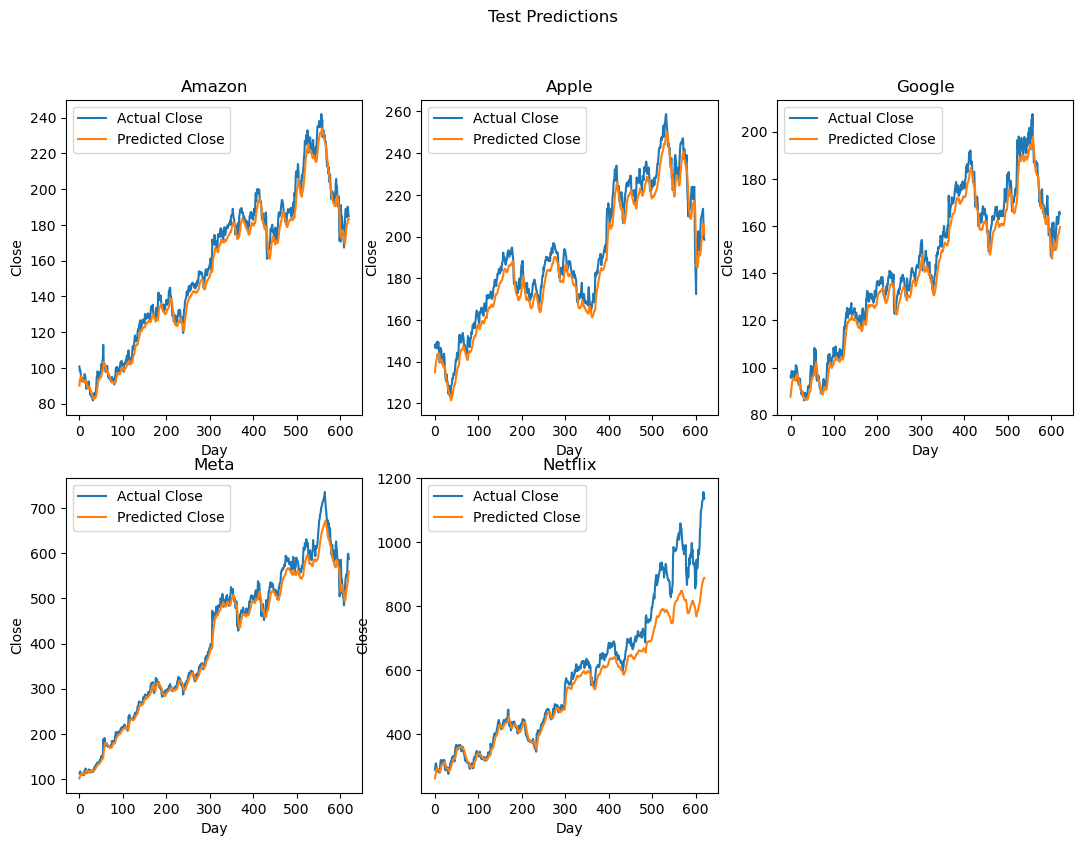

In [98]:
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_test_am, label='Actual Close')
plt.plot(predicted_test_am, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_test_ap, label='Actual Close')
plt.plot(predicted_test_ap, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_test_go, label='Actual Close')
plt.plot(predicted_test_go, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_test_me, label='Actual Close')
plt.plot(predicted_test_me, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_test_ne, label='Actual Close')
plt.plot(predicted_test_ne, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Test Predictions')
plt.show()

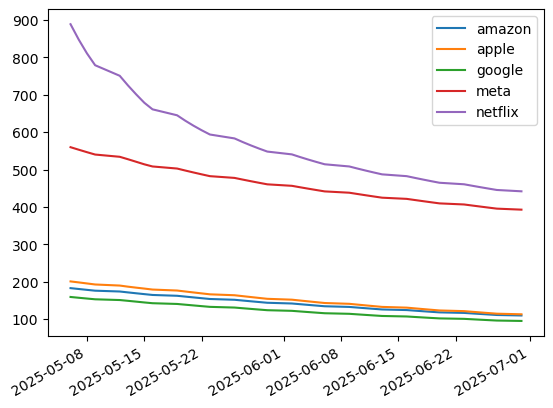

In [99]:
#Predict on future data:
def predict_future(model, X, num_iter,lookback):
    y_preds=[]
    with torch.no_grad():
        for _ in range(num_iter):
            y_pred = model(X.to(device))
            y_preds.append(y_pred.to('cpu').numpy().reshape(1))
            temp = torch.cat((X[:, 1:lookback, :], y_pred.unsqueeze(1)), dim=1)
            X = torch.cat((temp, X[:,lookback:, :]), dim=1)
    return y_preds

def make_input(company_np, scaler, lookback):
    company_pred_start = company_np[-1:]
    company_pred_start = np.delete(company_pred_start,0)
    company_pred_start = np.delete(company_pred_start,0)
    company_pred_start[:lookback] = scaler.transform(np.array([company_pred_start[:lookback]]))[0]
    company_pred_start = (company_pred_start.reshape((-1, lookback+5,1))).astype(float)
    company_pred_start = torch.tensor(company_pred_start).float()
    return company_pred_start

amazon_pred_start = make_input(amazon_np, scalerx, lookback)
amazon_preds = predict_future(final_days, amazon_pred_start, 40,lookback)
amazon_preds = np.array(amazon_preds)
amazon_preds_norm = scalery.inverse_transform(amazon_preds)

apple_pred_start = make_input(apple_np, scalerx, lookback)
apple_preds = predict_future(final_days, apple_pred_start, 40,lookback)
apple_preds = np.array(apple_preds)
apple_preds_norm = scalery.inverse_transform(apple_preds)

google_pred_start = make_input(google_np, scalerx, lookback)
google_preds = predict_future(final_days, google_pred_start, 40,lookback)
google_preds = np.array(google_preds)
google_preds_norm = scalery.inverse_transform(google_preds)

meta_pred_start = make_input(meta_np, scalerx, lookback)
meta_preds = predict_future(final_days, meta_pred_start, 40,lookback)
meta_preds = np.array(meta_preds)
meta_preds_norm = scalery.inverse_transform(meta_preds)

netflix_pred_start = make_input(netflix_np, scalerx, lookback)
netflix_preds = predict_future(final_days, netflix_pred_start, 40,lookback)
netflix_preds = np.array(netflix_preds)
netflix_preds_norm = scalery.inverse_transform(netflix_preds)

last_date = np.datetime64('2025-05-06 00:00:00')
future_dates = pd.date_range(start=last_date, periods=40, freq='B')

import matplotlib.dates as mdates
plt.plot(future_dates, amazon_preds_norm, label='amazon')
plt.plot(future_dates,apple_preds_norm, label='apple')
plt.plot(future_dates,google_preds_norm, label='google')
plt.plot(future_dates,meta_preds_norm, label='meta')
plt.plot(future_dates,netflix_preds_norm, label='netflix')
plt.legend()

plt.gcf().autofmt_xdate()  # Rotate date labels nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()
